In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar


In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:
data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape


(53, 206543)

In [4]:
indx = np.isfinite(data_loaded["best18k Parallax fiveSigmaDepth, band, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer"].values)
data_loaded["best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer"].iloc[indx] = data_loaded["best18k Parallax fiveSigmaDepth, band, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer"].iloc[indx]

for bandname in 'ugrizy':
    indx = np.isfinite(data_loaded["Median CoaddM5 band%s HealpixSlicer" % bandname].values)
    d1 = data_loaded["Median CoaddM5 %s HealpixSlicer" % bandname].values
    d1[indx] = data_loaded["Median CoaddM5 band%s HealpixSlicer" % bandname].iloc[indx].values
    data_loaded["Median CoaddM5 %s HealpixSlicer" % bandname] = d1

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_94768/2836973125.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_loaded["best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer"].iloc[

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
             'fOArea_750 fO All sky HealpixSlicer': 'fO Area 750',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            #'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            #'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            #'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Sum ColorSlope visitExposureTime > 19 HealpixSlicer': 'color slope',
            "Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer": "2day\ncolor slope",
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
             'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 3 pairs in 15 nights SNR=5 detection loss MoObjSlicer': 'Vatira 3pairs, 15days, snr=5',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'fO Area 750': '',
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'Vatira 3pairs, 15days, snr=5': "fraction",
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
         'color slope': 'N',
         '2day\ncolor slope': 'N',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan',
           'u', 'g', 'r', 'i', 'z', 'y']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [6]:
data_loaded["Median CoaddM5 g HealpixSlicer"]


run_name
baseline_v2.0_10yrs                 26.733479
baseline_v2.1_10yrs                 26.736248
baseline_v2.2_10yrs                 26.753646
baseline_v3.0_10yrs                 26.688123
baseline_v3.2_10yrs                 26.678103
baseline_v3.3_10yrs                 26.786124
baseline_v3.4_10yrs                 26.787451
baseline_v3.5_10yrs                 26.796821
baseline_v3.6_10yrs                 26.770742
baseline_v4.0_10yrs                 26.774161
baseline_v4.1_10yrs                 26.770161
baseline_v4.2_10yrs                 26.753683
baseline_v4.3.5_10yrs               26.748321
baseline_v5.0.0_10yrs               26.810518
ddf_acc_early_v5.0.0_10yrs          26.803993
ddf_accordion_short_v5.0.0_10yrs    26.811344
ddf_accordion_v5.0.0_10yrs          26.824967
ddf_all_dither_0.0_v5.0.0_10yrs     26.811277
ddf_all_dither_0.1_v5.0.0_10yrs     26.814006
ddf_all_dither_0.2_v5.0.0_10yrs     26.824366
ddf_all_dither_0.4_v5.0.0_10yrs     26.815235
ddf_all_dither_0.8_v5.0.0

In [7]:
[col for col in data_loaded.columns if "Median CoaddM5" in col]

['Median CoaddM5 All sky g band HealpixSlicer',
 'Median CoaddM5 All sky i band HealpixSlicer',
 'Median CoaddM5 All sky r band HealpixSlicer',
 'Median CoaddM5 All sky u band HealpixSlicer',
 'Median CoaddM5 All sky y band HealpixSlicer',
 'Median CoaddM5 All sky z band HealpixSlicer',
 'Median CoaddM5 HealpixSlicer',
 'Median CoaddM5 WFD g band HealpixSubsetSlicer',
 'Median CoaddM5 WFD i band HealpixSubsetSlicer',
 'Median CoaddM5 WFD r band HealpixSubsetSlicer',
 'Median CoaddM5 WFD u band HealpixSubsetSlicer',
 'Median CoaddM5 WFD y band HealpixSubsetSlicer',
 'Median CoaddM5 WFD z band HealpixSubsetSlicer',
 'Median CoaddM5 Yr 1 g band HealpixSlicer',
 'Median CoaddM5 Yr 1 i band HealpixSlicer',
 'Median CoaddM5 Yr 1 r band HealpixSlicer',
 'Median CoaddM5 Yr 1 u band HealpixSlicer',
 'Median CoaddM5 Yr 1 y band HealpixSlicer',
 'Median CoaddM5 Yr 1 z band HealpixSlicer',
 'Median CoaddM5 Yr 3-4 g band HealpixSlicer',
 'Median CoaddM5 Yr 3-4 i band HealpixSlicer',
 'Median CoaddM

In [8]:
data_loaded["best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer"]

run_name
baseline_v2.0_10yrs                 0.791090
baseline_v2.1_10yrs                 0.806946
baseline_v2.2_10yrs                 0.792998
baseline_v3.0_10yrs                 0.792704
baseline_v3.2_10yrs                 0.782553
baseline_v3.3_10yrs                 0.753860
baseline_v3.4_10yrs                 0.752667
baseline_v3.5_10yrs                 0.746976
baseline_v3.6_10yrs                 0.768760
baseline_v4.0_10yrs                 0.766651
baseline_v4.1_10yrs                 0.766510
baseline_v4.2_10yrs                 0.769841
baseline_v4.3.5_10yrs               0.770224
baseline_v5.0.0_10yrs               0.759337
ddf_acc_early_v5.0.0_10yrs          0.764819
ddf_accordion_short_v5.0.0_10yrs    0.765574
ddf_accordion_v5.0.0_10yrs          0.764699
ddf_all_dither_0.0_v5.0.0_10yrs     0.759679
ddf_all_dither_0.1_v5.0.0_10yrs     0.760041
ddf_all_dither_0.2_v5.0.0_10yrs     0.762821
ddf_all_dither_0.4_v5.0.0_10yrs     0.760435
ddf_all_dither_0.8_v5.0.0_10yrs     0.758595
d

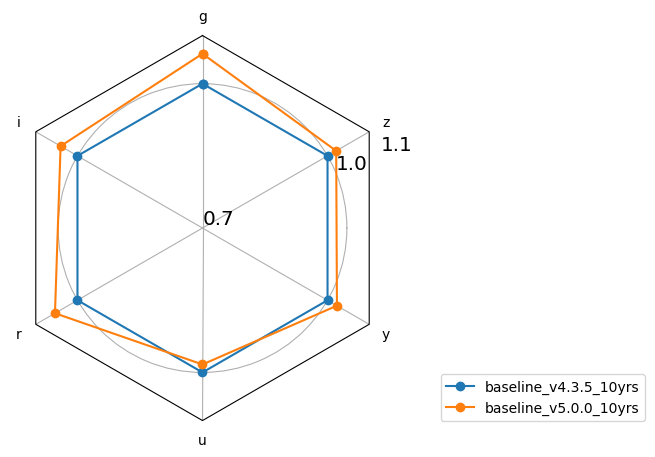

In [9]:
runs = ['baseline_v4.3.5_10yrs', 'baseline_v5.0.0_10yrs']
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v4.3.5_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.7, 1.0, 1.1], bbox_to_anchor=(1.65, 0))


In [10]:
mag_data.loc[runs]

,g,i,r,u,y,z
run_name,,,,,,
baseline_v4.3.5_10yrs,26.748321,26.354012,26.843619,25.548448,24.735330,25.704446
baseline_v5.0.0_10yrs,26.810518,26.394494,26.897606,25.531882,24.757917,25.725229


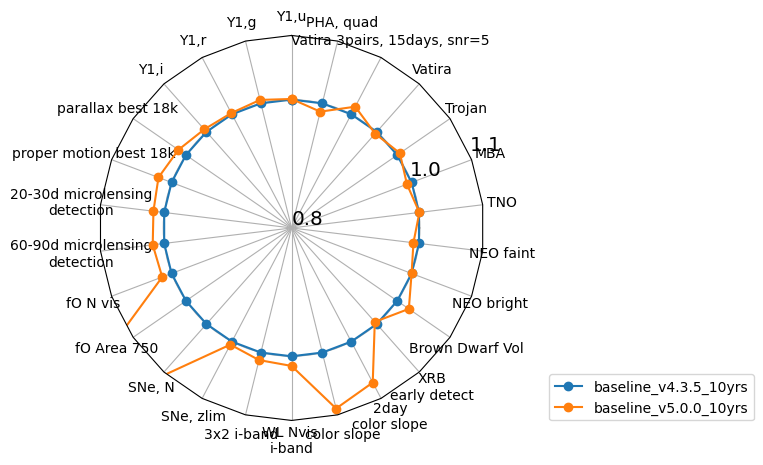

In [11]:
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v4.3.5_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.7, 0))


In [12]:
ndata

,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,fO Area 750,...,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"Vatira 3pairs, 15days, snr=5","PHA, quad"
run_name,,,,,,,,,,,,,,,,,,,,,
baseline_v4.3.5_10yrs,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000,1.000000,1.00000,...,1.000000,1.000000,1.0,1.0000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000
baseline_v5.0.0_10yrs,1.001011,1.005508,1.002236,1.005292,1.014338,1.021869,1.0169,1.018,1.015605,1.15771,...,0.995529,1.022045,1.0,0.9913,1.000624,0.992253,1.005099,0.9964,1.013451,0.986668


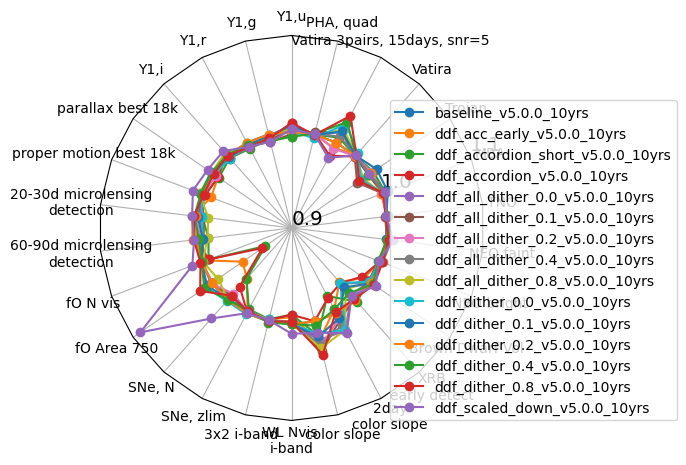

In [13]:
runs = ['baseline_v5.0.0_10yrs'] + [run for run in data_loaded.index if 'ddf' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.0.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


In [14]:
ndata

,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,fO Area 750,...,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"Vatira 3pairs, 15days, snr=5","PHA, quad"
run_name,,,,,,,,,,,,,,,,,,,,,
baseline_v5.0.0_10yrs,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.0000,1.000000,1.000000,...,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000
ddf_acc_early_v5.0.0_10yrs,1.004329,0.993153,0.996406,1.002131,0.992833,0.989499,1.0040,1.0037,0.994878,0.961742,...,0.975050,0.991438,0.9982,1.000102,0.997548,1.004133,1.000110,1.0015,0.994050,1.000266
ddf_accordion_short_v5.0.0_10yrs,1.005483,0.995270,0.993060,0.996992,0.991853,0.997387,0.9933,0.9870,0.992318,0.933157,...,1.002495,0.996951,0.9980,1.001532,0.999819,1.004232,1.003065,0.9999,1.005950,0.999974
ddf_accordion_v5.0.0_10yrs,1.004329,0.993153,0.996406,1.002131,0.992988,0.995806,1.0004,0.9990,0.992318,0.936723,...,0.976547,0.989019,0.9982,1.002513,1.000452,1.001070,0.997104,0.9991,0.984897,1.000933
ddf_all_dither_0.0_v5.0.0_10yrs,1.002742,0.998257,0.998141,1.002381,0.999550,1.001404,0.9960,0.9931,1.000000,1.000973,...,0.993513,0.997562,0.9968,1.001208,0.999386,1.001060,0.984055,0.9998,1.013272,0.998552
ddf_all_dither_0.1_v5.0.0_10yrs,0.997691,0.992033,0.996282,0.999624,0.999074,1.000904,0.9919,0.9920,1.000000,1.000973,...,0.998004,0.997457,0.9966,1.002543,0.999488,1.001679,0.982768,0.9989,1.012357,1.002706
ddf_all_dither_0.2_v5.0.0_10yrs,1.003752,0.997386,0.997645,1.001253,0.995432,0.998506,1.0002,0.9952,1.000000,1.001189,...,0.995509,1.000172,0.9968,1.001186,0.999503,0.999855,1.001430,0.9997,0.993135,1.000913
ddf_all_dither_0.4_v5.0.0_10yrs,1.004329,0.996639,0.995291,0.996365,0.998556,0.999831,1.0014,0.9987,0.998720,1.001513,...,0.977545,0.999547,1.0012,1.004767,0.998194,1.002679,0.984936,1.0009,1.007323,1.000677
ddf_all_dither_0.8_v5.0.0_10yrs,1.003896,0.996763,0.997521,1.004261,1.000978,1.002320,0.9872,0.9880,0.998720,0.992921,...,0.984531,0.999848,0.9968,0.999792,0.999692,1.000843,0.990236,1.0013,1.016018,0.997604


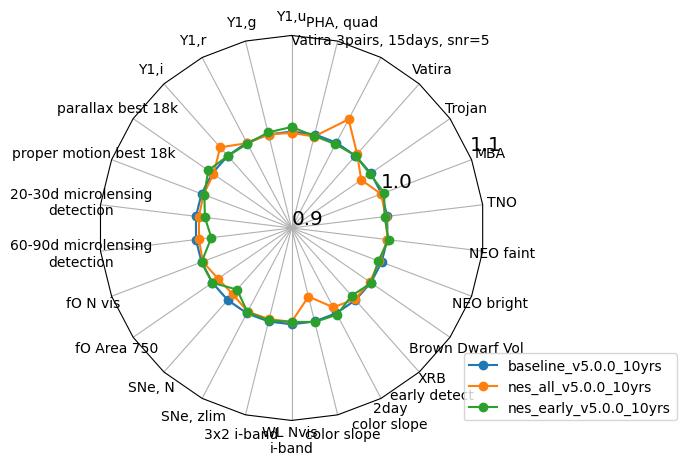

In [15]:
runs = ['baseline_v5.0.0_10yrs'] + [run for run in data_loaded.index if 'nes' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.0.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


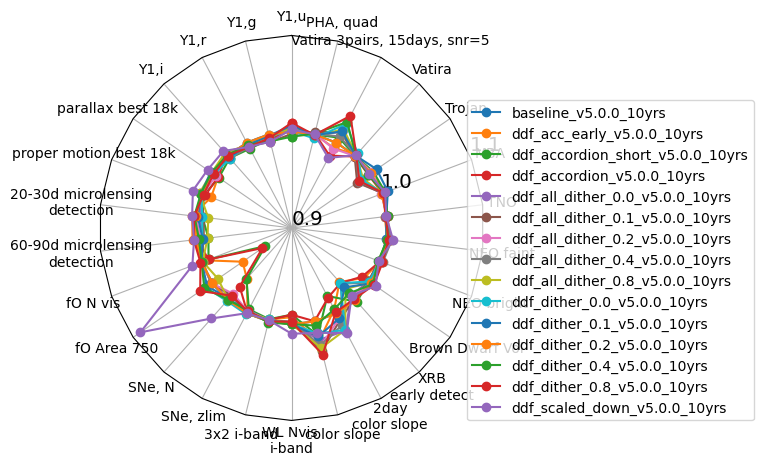

In [16]:
runs = ['baseline_v5.0.0_10yrs'] +[run for run in data.index if 'ddf' in run]

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.0.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.7, 0))

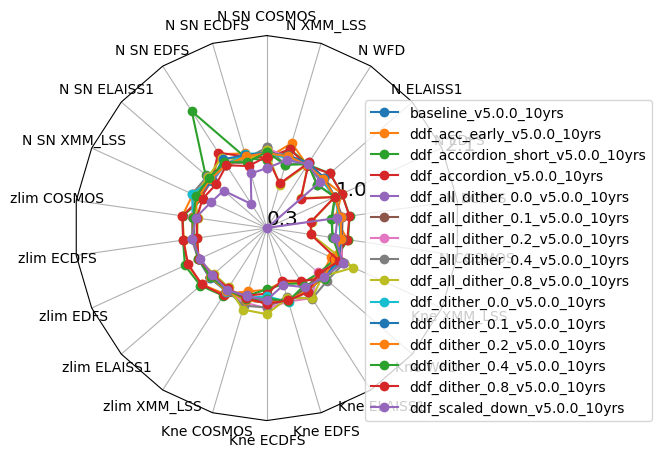

In [17]:
ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                 norm_run='baseline_v5.0.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.3, 1.0, 2.1], bbox_to_anchor=(1.5, 0))


In [18]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs', 'baseline_v3.4_10yrs', 
          'baseline_v3.5_10yrs', 'baseline_v3.6_10yrs', 'baseline_v4.0_10yrs', 'baseline_v4.1_10yrs',
         'baseline_v4.2_10yrs', "baseline_v4.3.5_10yrs","baseline_v5.0.0_10yrs"
        ]

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data

,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,fO Area 750,...,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"Vatira 3pairs, 15days, snr=5","PHA, quad"
run_name,,,,,,,,,,,,,,,,,,,,,
retro_baseline_v2.0_10yrs,0.893276,0.949104,0.960964,0.958616,0.804364,0.176701,0.0878,0.1568,848.0,18128.742737,...,720.0,179634.826127,0.9048,0.624144,0.705922,0.943673,0.667514,0.0000,0.0000,0.847855
baseline_v2.0_10yrs,0.955776,0.981594,0.994441,0.997035,0.791090,0.184088,0.3119,0.4348,839.0,18620.568813,...,1882.0,168080.497664,0.9294,0.642165,0.719712,0.919119,0.588234,0.0039,0.0001,0.859388
baseline_v2.1_10yrs,0.948661,0.984188,0.996912,0.999012,0.806946,0.188258,0.3141,0.4319,838.0,18676.801487,...,1918.0,163809.598961,0.9286,0.647818,0.723396,0.927584,0.609144,0.0017,0.0004,0.865595
baseline_v2.2_10yrs,0.871233,0.914268,0.993947,0.998023,0.792998,0.186345,0.3268,0.4487,830.0,18627.283162,...,1921.0,172447.199022,0.9304,0.657736,0.723964,0.933674,0.615614,0.0008,0.0000,0.858646
baseline_v3.0_10yrs,0.813058,0.901174,0.993823,0.999135,0.792704,0.185683,0.3232,0.4528,795.0,17809.811151,...,1952.0,168026.998037,0.9326,0.642444,0.722371,0.924274,0.611475,0.0376,0.0002,0.888025
baseline_v3.2_10yrs,0.973633,0.982335,0.996170,0.995800,0.782553,0.185369,0.3437,0.4869,805.0,18454.388671,...,2048.0,174046.841812,0.9460,0.642240,0.720853,0.926557,0.589189,0.4628,0.2353,0.893770
baseline_v3.3_10yrs,0.987305,0.992712,0.997529,0.996294,0.753860,0.179042,0.3817,0.5233,811.0,18698.623122,...,2090.0,188214.630011,0.9442,0.659856,0.722551,0.942687,0.630093,0.4606,0.2317,0.906586
baseline_v3.4_10yrs,0.981306,0.990364,0.995553,0.997529,0.752667,0.177617,0.3653,0.5179,817.0,18843.820922,...,2043.0,188718.767448,0.9478,0.667858,0.727785,0.943605,0.634531,0.4634,0.2357,0.904225
baseline_v3.5_10yrs,0.982561,0.995182,0.999012,0.997406,0.746976,0.175842,0.3733,0.5191,803.0,18226.100799,...,2132.0,181695.683401,0.9468,0.669059,0.725880,0.938794,0.604954,0.4672,0.2393,0.912349


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_94768/2854613832.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


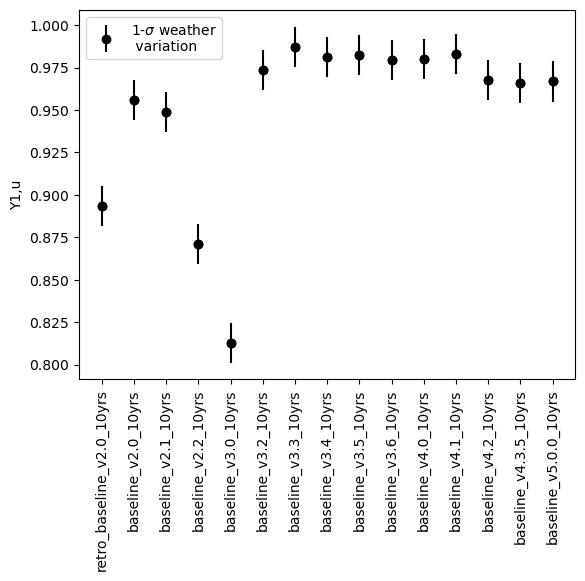

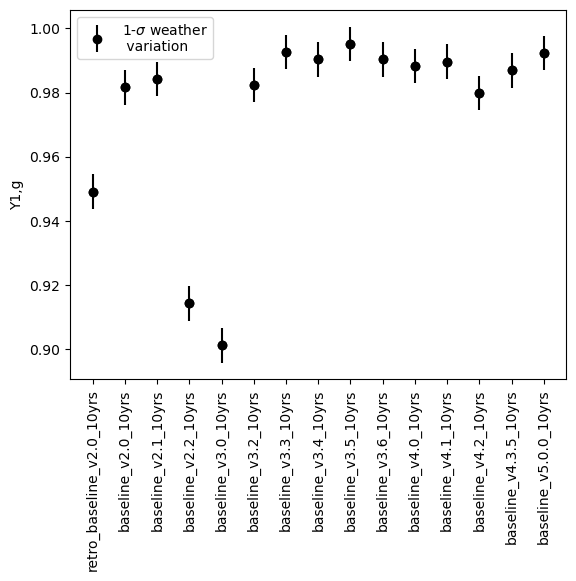

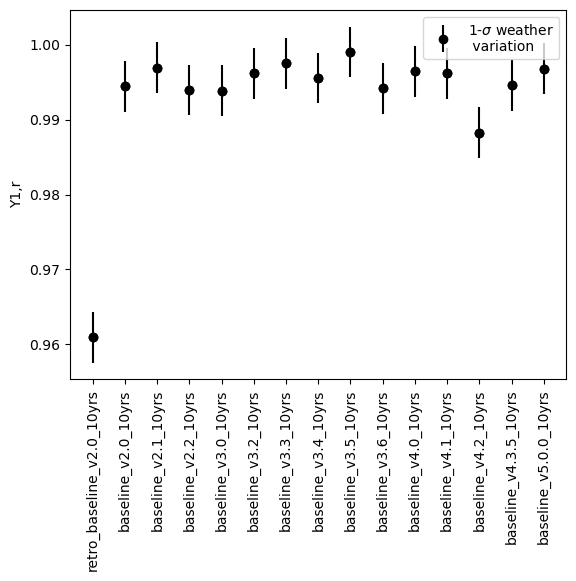

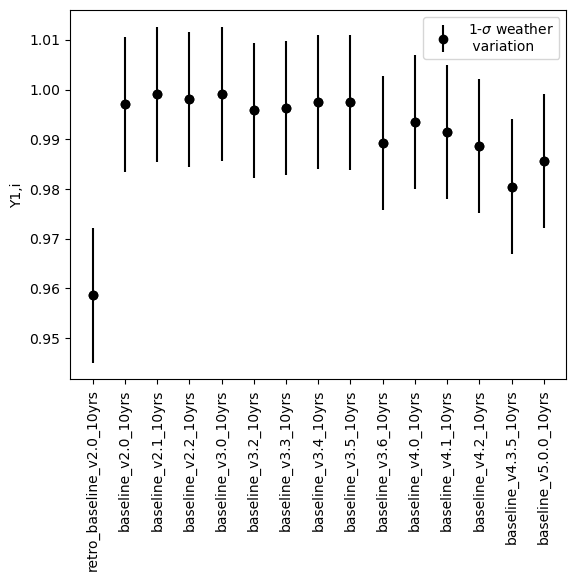

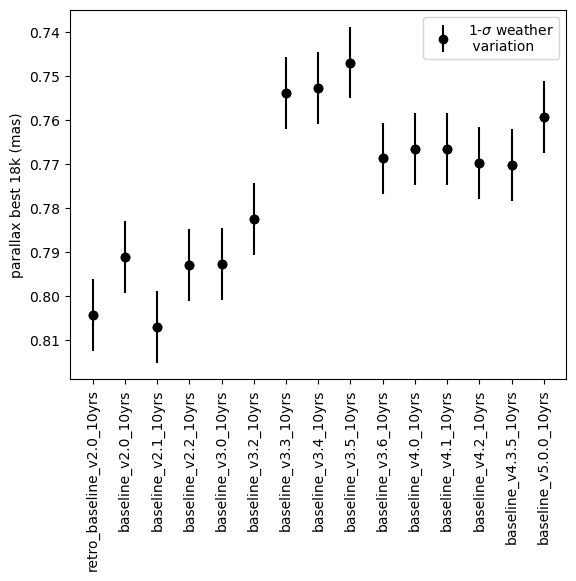

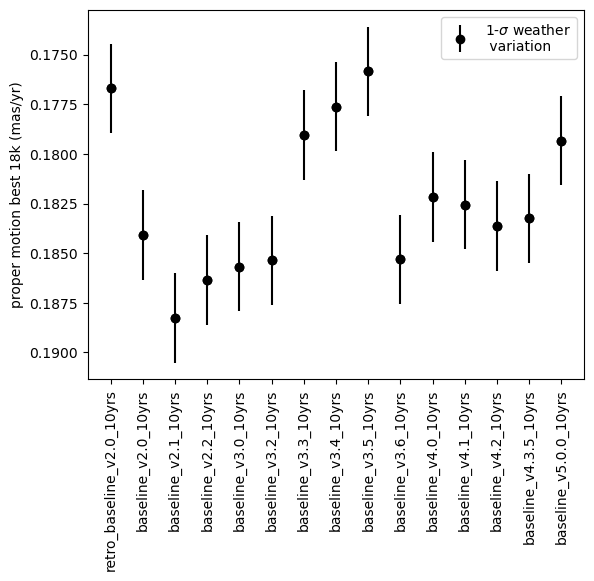

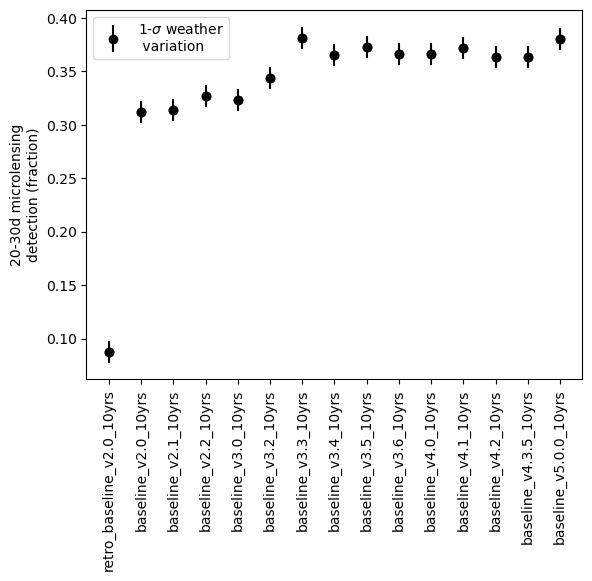

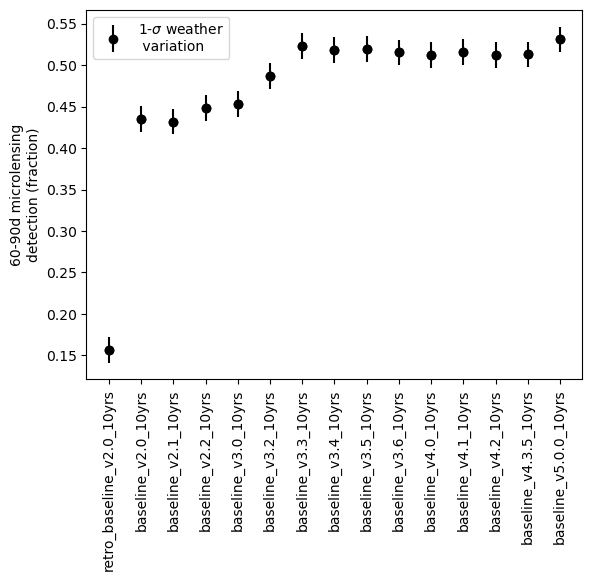

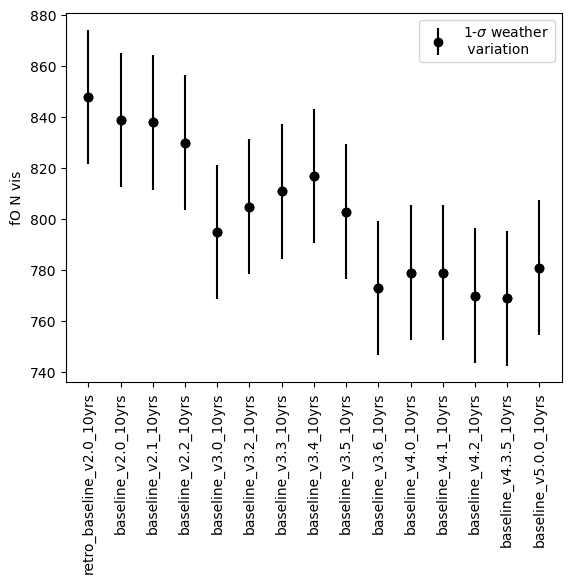

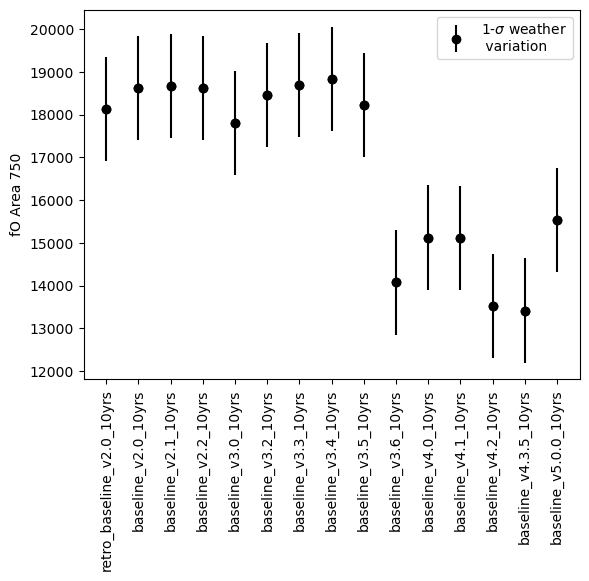

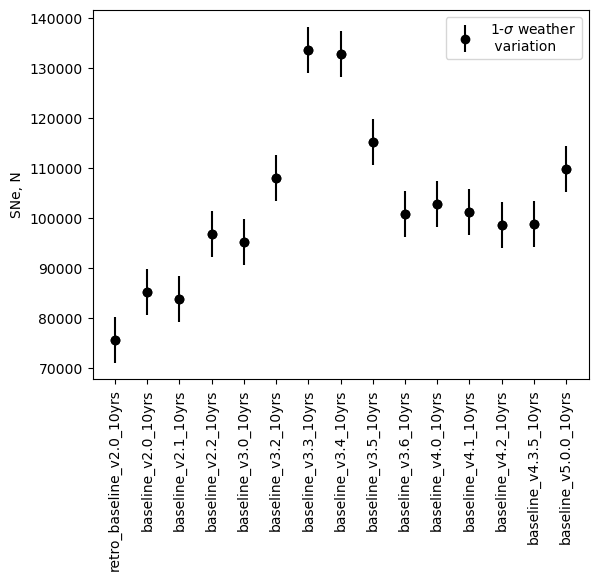

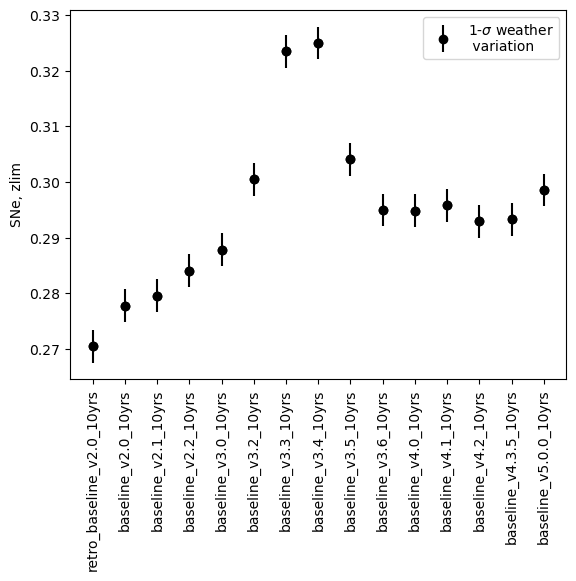

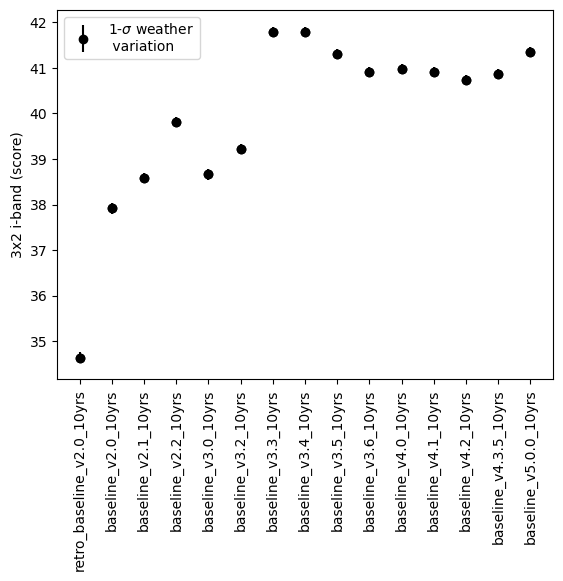

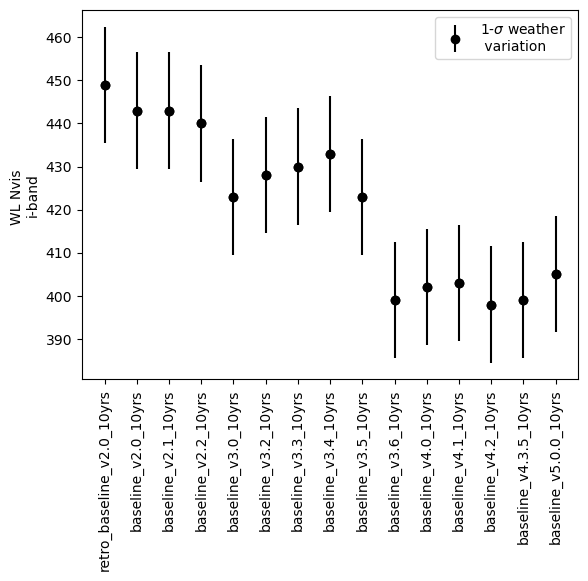

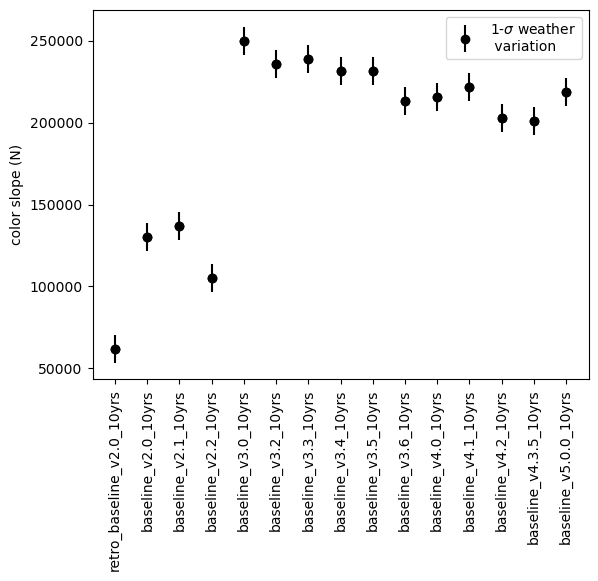

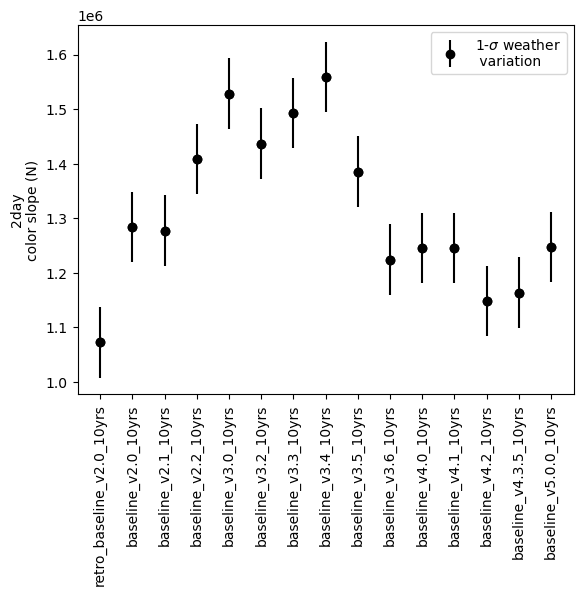

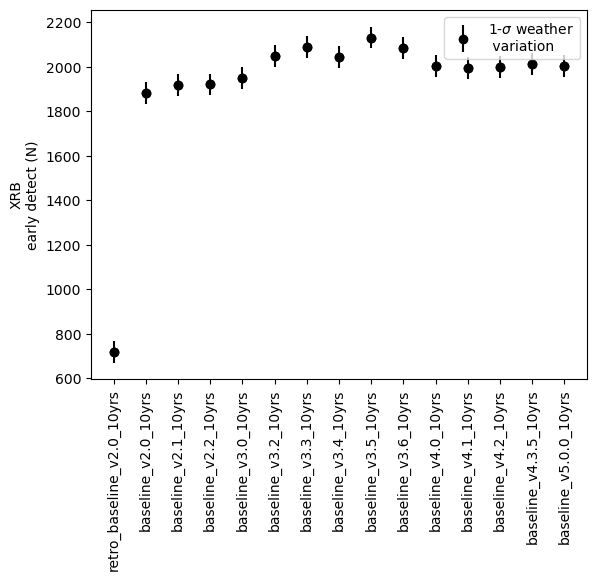

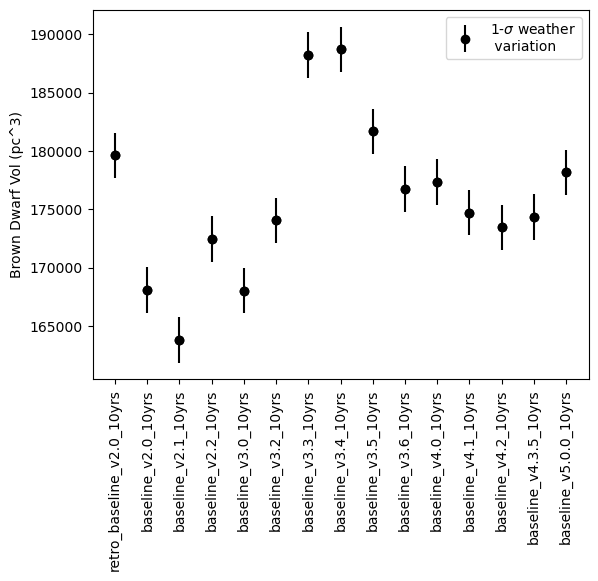

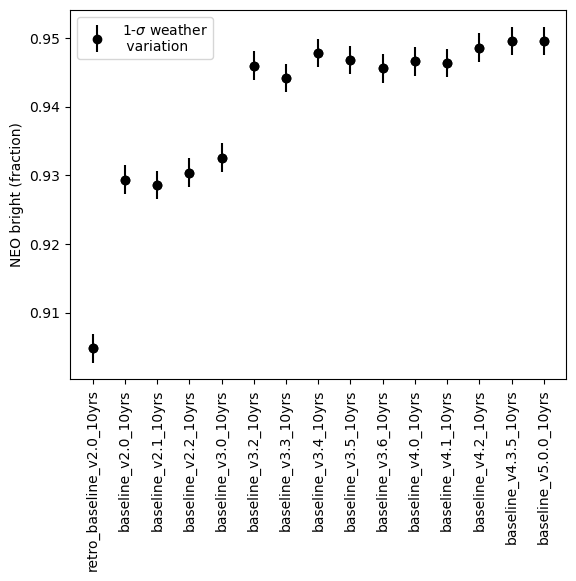

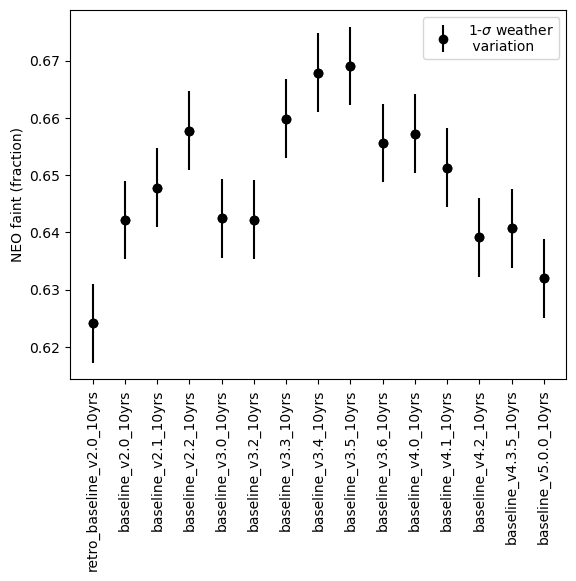

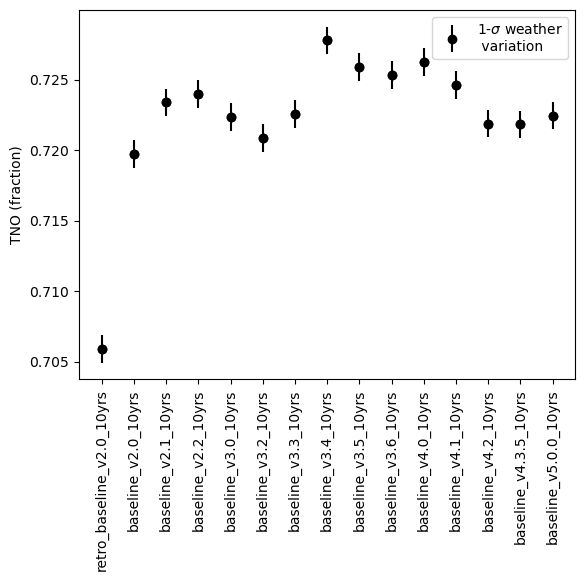

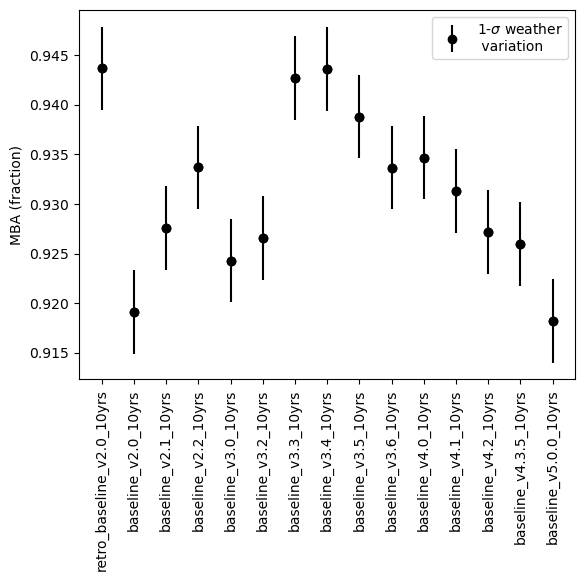

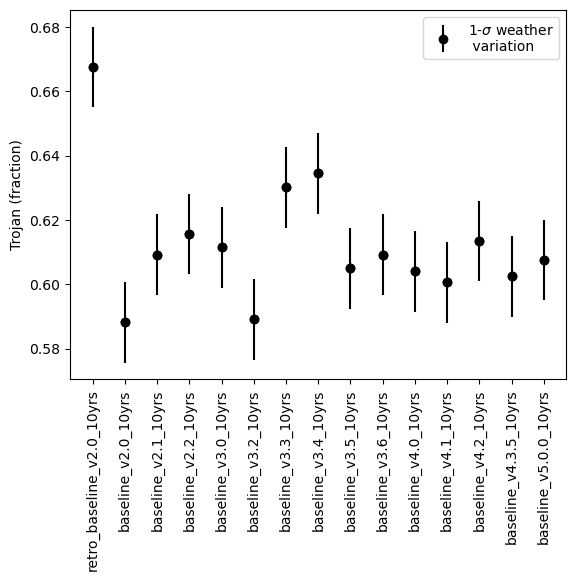

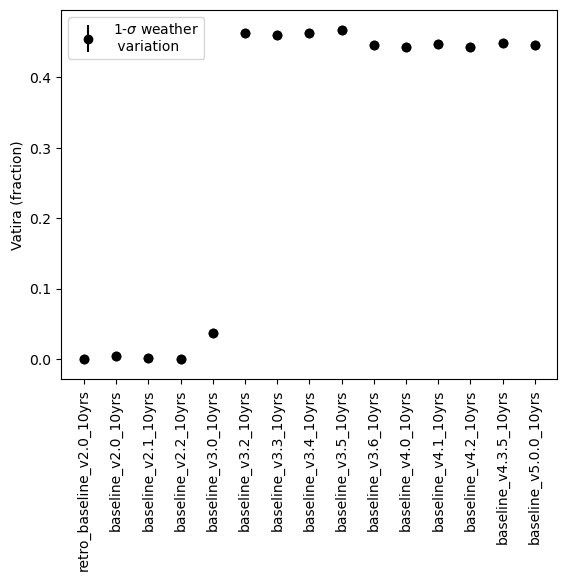

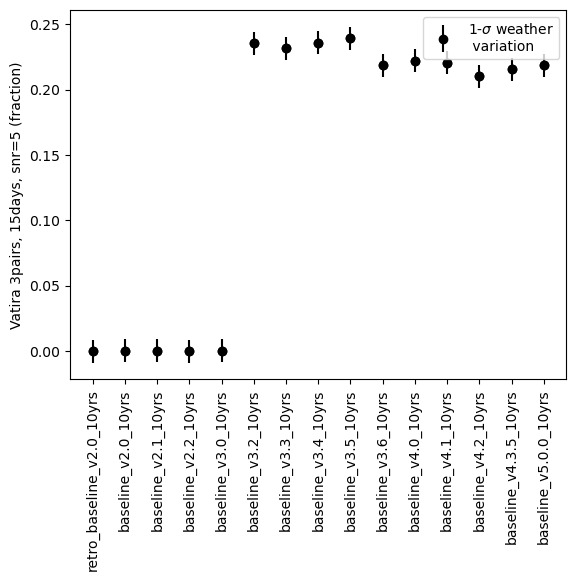

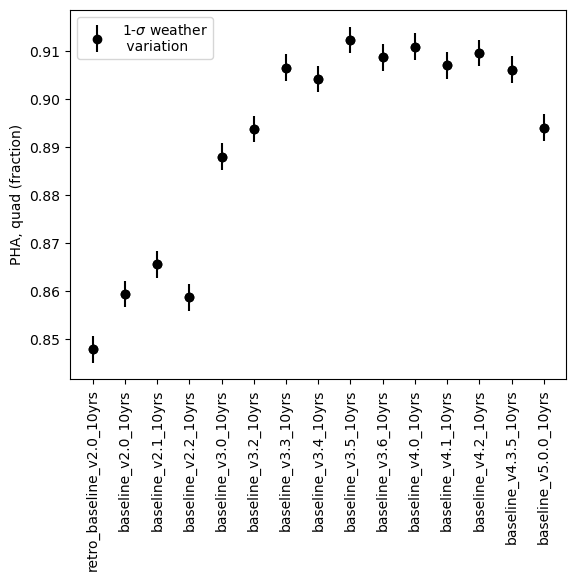

In [19]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])